# CSCA 5642 Final Project - Classification of malignant lymphoma tissues

## This project uses data downloaded from a Kaggle Dataset - Malignant Lymphoma Classification (https://www.kaggle.com/datasets/andrewmvd/malignant-lymphoma-classification?select=MCL). It contains images of the three classes of lymphoma, CLL (chronic lymphocytic leukemia), FL (follicular lymphoma), and MCL (mantle cell lymphoma). There are about 100-150 images of each type of lymphoma. The goal of this project will be to train a neural network model to recognize the types of lymphoma to classify the images.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

## EDA and Data Cleaning

#### Will start by reading in the image data and converting the images from tif files to png files so they are compatible with Keras.

In [2]:
def read_images(data_path, output_path):
    for filename in os.listdir(data_path):
        filepath = os.path.join(data_path, filename)
        if not os.access(filepath, os.R_OK):
            print(f"Cannot read {filename}")
        os.makedirs(output_path, exist_ok=True)
        output_file = os.path.join(output_path, os.path.splitext(filename)[0] + ".png")
        img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
        if img is None:
            print(filename)
            continue
        cv2.imwrite(output_file, img)

In [3]:
CLL_path = 'data/CLL/'
CLL_output_path = 'converted_dataset/CLL'
FL_path = 'data/FL/'
FL_output_path = 'converted_dataset/FL'
MCL_path = 'data/MCL/'
MCL_output_path = 'converted_dataset/MCL'

In [4]:
read_images(CLL_path, CLL_output_path)
read_images(FL_path, FL_output_path)
read_images(MCL_path, MCL_output_path)

#### Check size of a few images from each class

In [5]:
def check_size(dirpath):
    for i,filename in enumerate(os.listdir(dirpath)):
        filepath = os.path.join(dirpath, filename)
        img = Image.open(filepath)
        width, height = img.size
        print(dirpath, 'Image sizes:', width, 'x', height)
        if i == 4:
            break

In [6]:
check_size('converted_dataset/CLL')
check_size('converted_dataset/FL')
check_size('converted_dataset/MCL')

converted_dataset/CLL Image sizes: 1388 x 1040
converted_dataset/CLL Image sizes: 1388 x 1040
converted_dataset/CLL Image sizes: 1388 x 1040
converted_dataset/CLL Image sizes: 1388 x 1040
converted_dataset/CLL Image sizes: 1388 x 1040
converted_dataset/FL Image sizes: 1388 x 1040
converted_dataset/FL Image sizes: 1388 x 1040
converted_dataset/FL Image sizes: 1388 x 1040
converted_dataset/FL Image sizes: 1388 x 1040
converted_dataset/FL Image sizes: 1388 x 1040
converted_dataset/MCL Image sizes: 1388 x 1040
converted_dataset/MCL Image sizes: 1388 x 1040
converted_dataset/MCL Image sizes: 1388 x 1040
converted_dataset/MCL Image sizes: 1388 x 1040
converted_dataset/MCL Image sizes: 1388 x 1040


#### Images look to be all the same size.

#### Convert data into a tf dataset from directory. Will split into a train and validation set.



In [7]:
width = 1388
height = 1040

train_dataset = tf.keras.utils.image_dataset_from_directory(
    'converted_dataset/',
    image_size=(width,height),
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=123
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    'converted_dataset/',
    image_size=(width,height),
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=123
)

Found 374 files belonging to 3 classes.
Using 300 files for training.
Found 374 files belonging to 3 classes.
Using 74 files for validation.


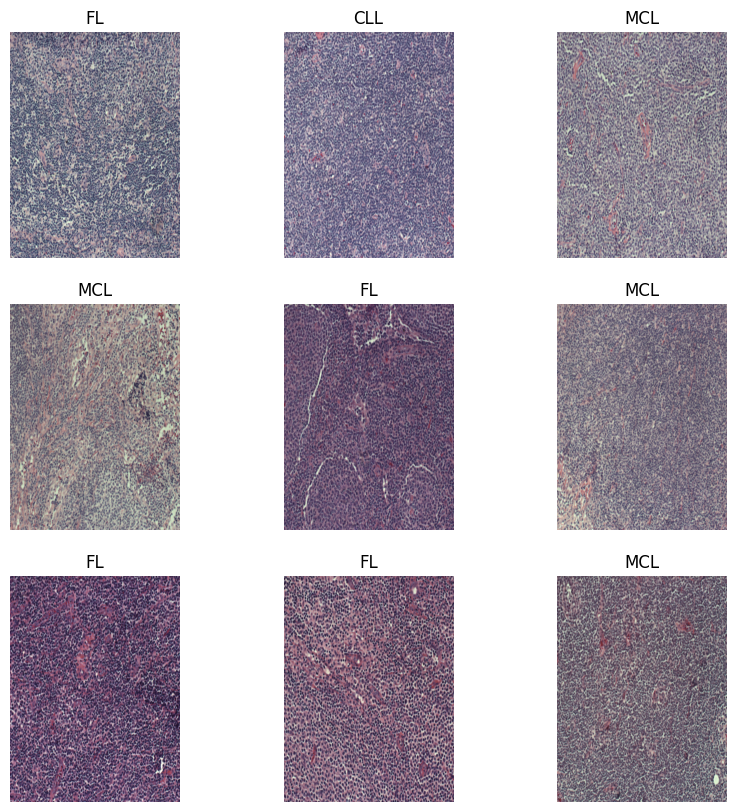

In [ ]:
classes = train_dataset.class_names

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i].numpy()])
        plt.axis("off")
    break

[113, 139, 122]


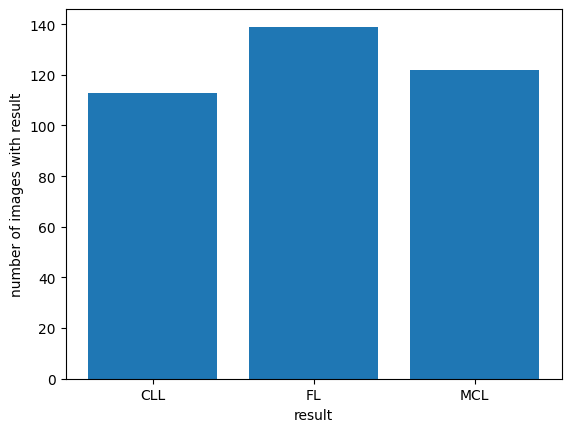

In [ ]:
vals = [len(os.listdir('data/CLL/')), len(os.listdir('data/FL/')), len(os.listdir('data/MCL/'))]
print(vals)
plt.bar(['CLL','FL','MCL'],vals)
plt.xlabel('result')
plt.ylabel('number of images with result')
plt.show()

## Data preprocessing
#### Will one-hot encode the labels and introduce data augmentation to help with overfitting.

In [8]:
def one_hot_labels(images, labels):
    labels = tf.one_hot(tf.cast(labels, tf.int32), depth=3)  # Assuming 3 classes
    return images, labels

train_dataset = train_dataset.map(one_hot_labels)
val_dataset = val_dataset.map(one_hot_labels)

#### Introduce data augmentation for training data and normalization to help with overfitting and improve model performance:

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomContrast(0.2)
])

In [10]:
def preprocess_data(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    images = data_augmentation(images, training=True)

    return images, labels

def preprocess_val(images, labels):
    images = tf.cast(images, tf.float32) / 255.0
    return images, labels

train_dataset = train_dataset.map(preprocess_data)
val_dataset = val_dataset.map(preprocess_val)

## Build Model Architecture
#### I will start with a conv-conv-maxpool architecture for image classification. I'm including kernel regularizers in all conv layers and dense layers to help with overfitting since our dataset is pretty small. I'm also including batch normalization layers and dropout layers within each conv-conv-pool segment, also to prevent overfitting. The images are large, so there may need to be quite a few of these segments, but that is something I set up the function to be able to easily tune. We'll start with 3 total conv-conv-pool segments. After the specified number of segments, I've included two dense layers for classification. The final layer uses a softmax activation for multiclass classification.

#### I'm going with an Adam optimizer for this, with a categorical crossentropy loss function and gradient clipping.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2

def build_CCM_model(n_filts=[12,10,8], s_filts=[5,3,3], pool_size=[4,2,2], n=2, strides = [2,1,1], padding='same', conv_activation='relu', learning_rate = 0.001):

    layer0 = [Conv2D(n_filts[0], s_filts[0], activation = conv_activation, strides = strides[0], padding = 'valid', input_shape=(width,height,3),kernel_regularizer=l2(0.01)),
                     BatchNormalization(), Conv2D(n_filts[0],s_filts[0],activation=conv_activation, strides = strides[0], kernel_regularizer=l2(0.01), padding = padding),
                     MaxPooling2D(pool_size[0])]

    m = layer0
    m.append(LeakyReLU())
    m.append(Dropout(0.9))

    if n>1:
        for i in range(1,n+1):
          layer = [Conv2D(n_filts[i], s_filts[i], activation = conv_activation, padding = padding, strides = strides[i], kernel_regularizer=l2(0.01)),
                     BatchNormalization(),Conv2D(n_filts[i],s_filts[i],activation=conv_activation, padding = padding, strides = strides[i], kernel_regularizer=l2(0.01)),
                     MaxPooling2D(pool_size[i])]
          m.append(layer[0])
          m.append(layer[1])
          m.append(layer[2])
          m.append(layer[3])
          m.append(LeakyReLU())
          m.append(Dropout(0.6))

    m.append(Flatten())
    m.append(Dense(32,activation='tanh',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    m.append(Dense(3,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.01)))

    model = Sequential(m)
    model.compile(optimizer = Adam(learning_rate = learning_rate, clipnorm=1.2), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

In [ ]:
model1 = build_CCM_model()
model1.summary()

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_311 (Conv2D)                  │ (None, 694, 520, 12)        │             912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_114              │ (None, 694, 520, 12)        │              48 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_312 (Conv2D)                  │ (None, 347, 260, 12)        │           3,612 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_155 (MaxPooling2D)     │ (None, 86, 65, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_154 (Dropout)                │ (None, 86, 65, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_313 (Conv2D)                  │ (None, 86, 65, 10)          │           1,090 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_115              │ (None, 86, 65, 10)          │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_314 (Conv2D)                  │ (None, 86, 65, 10)          │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_156 (MaxPooling2D)     │ (None, 43, 32, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_155 (Dropout)                │ (None, 43, 32, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_315 (Conv2D)                  │ (None, 43, 32, 8)           │             728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_116              │ (None, 43, 32, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_316 (Conv2D)                  │ (None, 43, 32, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_157 (MaxPooling2D)     │ (None, 21, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_156 (Dropout)                │ (None, 21, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_41 (Flatten)                 │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 16)                  │          43,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,031 (199.34 KB)

 Trainable params: 50,971 (199.11 KB)

 Non-trainable params: 60 (240.00 B)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
m1_hist = model1.fit(train_dataset, validation_data = val_dataset, epochs = 15, callbacks = [reduce_lr])

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 170s 14s/step - accuracy: 0.3516 - loss: 1.6756 - val_accuracy: 0.3243 - val_loss: 1.1890 - learning_rate: 0.0010
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 158s 14s/step - accuracy: 0.3930 - loss: 1.1883 - val_accuracy: 0.3243 - val_loss: 1.1875 - learning_rate: 0.0010
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 158s 14s/step - accuracy: 0.3496 - loss: 1.1869 - val_accuracy: 0.3243 - val_loss: 1.1854 - learning_rate: 0.0010
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.3406 - loss: 1.1846 - val_accuracy: 0.3243 - val_loss: 1.1834 - learning_rate: 0.0010
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 158s 14s/step - accuracy: 0.4140 - loss: 1.1814 - val_accuracy: 0.3243 - val_loss: 1.1816 - learning_rate: 0.0010
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.3859 - loss: 1.1798 - val_accuracy: 0.3243 - val_loss: 1.1800 - learning_rate: 0.0010
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 156s 14s/step - accuracy: 0.3619 - loss: 1.1781 - 

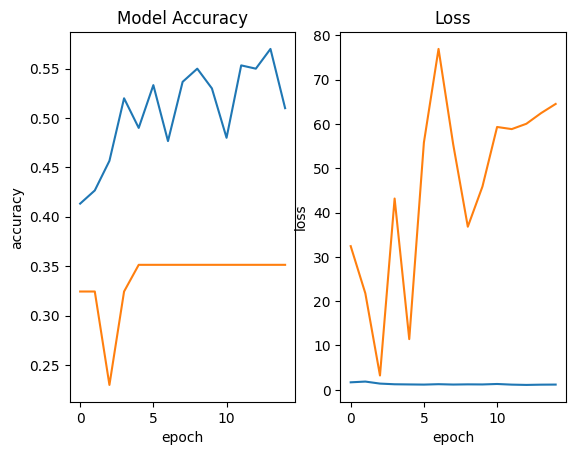

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(m1_hist.history['accuracy'], label='Train Accuracy')
ax1.plot(m1_hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax2.plot(m1_hist.history['loss'], label='Train Loss')
ax2.plot(m1_hist.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
fig.show()

#### Some serious overfitting is ocurring. Will try another model with a less complex architecture and assess. Also introduced one-hot encoding for training labels to use categorical crossentropy loss function instead of sparse categorical crossentropy.

In [ ]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

In [ ]:
model2 = build_CCM_model(n=1, learning_rate = 0.0001)
model2.summary()
m2_hist = model2.fit(train_dataset, validation_data = val_dataset, epochs = 25, callbacks = [reduce_lr])

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_317 (Conv2D)                  │ (None, 694, 520, 12)        │             912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_117              │ (None, 694, 520, 12)        │              48 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_318 (Conv2D)                  │ (None, 347, 260, 12)        │           3,612 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_158 (MaxPooling2D)     │ (None, 86, 65, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_157 (Dropout)                │ (None, 86, 65, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_42 (Flatten)                 │ (None, 67080)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 16)                  │       1,073,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,077,919 (4.11 MB)

 Trainable params: 1,077,895 (4.11 MB)

 Non-trainable params: 24 (96.00 B)

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 164s 14s/step - accuracy: 0.4100 - loss: 1.1509 - val_accuracy: 0.3243 - val_loss: 108.5623 - learning_rate: 1.0000e-04
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.4164 - loss: 1.1197 - val_accuracy: 0.3243 - val_loss: 171.9199 - learning_rate: 1.0000e-04
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.4346 - loss: 1.0965 - val_accuracy: 0.3243 - val_loss: 94.7011 - learning_rate: 1.0000e-04
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.5071 - loss: 1.0787 - val_accuracy: 0.3243 - val_loss: 126.4286 - learning_rate: 1.0000e-04
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.4733 - loss: 1.0790 - val_accuracy: 0.3243 - val_loss: 185.6624 - learning_rate: 1.0000e-04
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.4984 - loss: 1.1000 - val_accuracy: 0.3108 - val_loss: 145.2372 - learning_rate: 1.0000e-04
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 159s 14s/step -

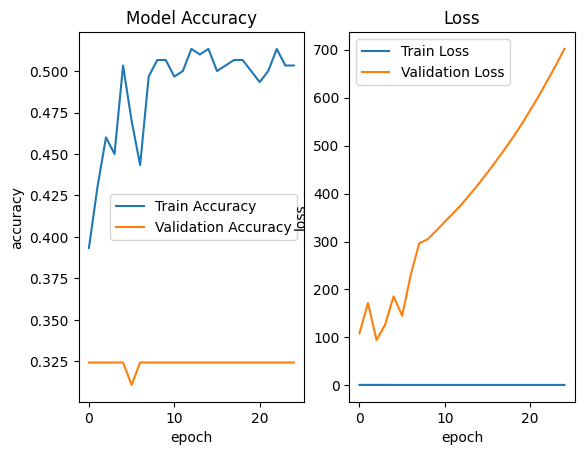

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(m2_hist.history['accuracy'], label='Train Accuracy')
ax1.plot(m2_hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend()
ax2.plot(m2_hist.history['loss'], label='Train Loss')
ax2.plot(m2_hist.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.legend()
fig.show()

#### Added stride in first layer

In [ ]:
model3 = build_CCM_model(n_filts=[32,32,16,8,8], s_filts=[5,3,3,3,3], pool_size=[4,4,2,2,2], n=4, strides = [2,1,1,1,1], learning_rate = 0.00001)
model3.summary()
m3_hist = model3.fit(train_dataset, validation_data = val_dataset, epochs = 20)

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_329 (Conv2D)                  │ (None, 694, 520, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_123              │ (None, 694, 520, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_330 (Conv2D)                  │ (None, 347, 260, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_164 (MaxPooling2D)     │ (None, 86, 65, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_163 (Dropout)                │ (None, 86, 65, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_331 (Conv2D)                  │ (None, 86, 65, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_124              │ (None, 86, 65, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_332 (Conv2D)                  │ (None, 86, 65, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_165 (MaxPooling2D)     │ (None, 21, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_164 (Dropout)                │ (None, 21, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_333 (Conv2D)                  │ (None, 21, 16, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_125              │ (None, 21, 16, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_334 (Conv2D)                  │ (None, 21, 16, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_166 (MaxPooling2D)     │ (None, 10, 8, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_165 (Dropout)                │ (None, 10, 8, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_335 (Conv2D)                  │ (None, 10, 8, 8)            │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_126              │ (None, 10, 8, 8)            │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_336 (Conv2D)                  │ (None, 10, 8, 8)            │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_167 (MaxPooling2D)     │ (None, 5, 4, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 57,379 (224.14 KB)

 Trainable params: 57,187 (223.39 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 173s 14s/step - accuracy: 0.3513 - loss: 1.9593 - val_accuracy: 0.3243 - val_loss: 2.6983
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.3085 - loss: 2.0657 - val_accuracy: 0.3243 - val_loss: 3.0897
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.2927 - loss: 2.0324 - val_accuracy: 0.3243 - val_loss: 3.5928
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.2928 - loss: 2.0220 - val_accuracy: 0.3243 - val_loss: 4.2236
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.3311 - loss: 1.8648 - val_accuracy: 0.3243 - val_loss: 4.9974
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.3134 - loss: 2.0228 - val_accuracy: 0.3243 - val_loss: 5.9176
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.3332 - loss: 1.9655 - val_accuracy: 0.3243 - val_loss: 6.9928
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 14s/step - accuracy: 0.3769 - loss: 1.8194 - val_accuracy: 0.

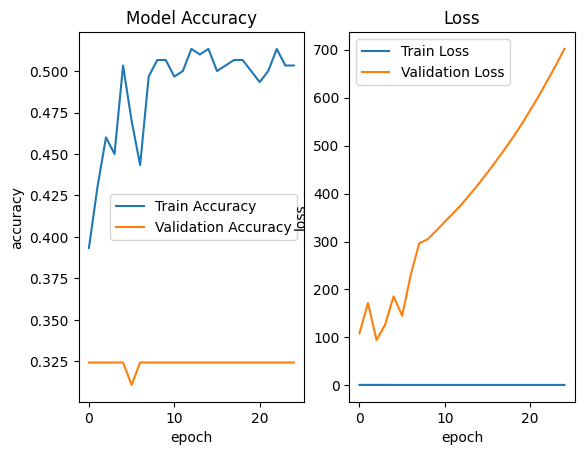

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(m2_hist.history['accuracy'], label='Train Accuracy')
ax1.plot(m2_hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend()
ax2.plot(m2_hist.history['loss'], label='Train Loss')
ax2.plot(m2_hist.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.legend()
fig.show()

## This architecture isn't working very well. Model is overfitting and accuracy is low. Will try a new simpler model build function with a conv-pool architecture instead of conv-conv-pool. Will continue to include normalization and dropout layers, but without the LeakyReLU activation layers.

In [ ]:
def build_CMD_model(n_filts=[12,10,8], s_filts=[5,3,3], pool_size=[4,2,2], n=2, strides = [2,1,1], padding='same', conv_activation='relu', learning_rate = 0.00001):

    layer0 = [Conv2D(n_filts[0], s_filts[0], activation = conv_activation, strides = strides[0], padding = padding, input_shape=(width,height,3),kernel_regularizer=l2(0.01)),
                     BatchNormalization(), MaxPooling2D(pool_size[0]), Dropout(0.3)
              ]

    m = layer0

    if n>1:
        for i in range(1,n+1):
          layer = [Conv2D(n_filts[i], s_filts[i], activation = conv_activation, padding = padding, strides = strides[i], kernel_regularizer=l2(0.01)),
                     MaxPooling2D(pool_size[i])]
          m.append(layer[0])
          m.append(layer[1])
          m.append(BatchNormalization())
          m.append(Dropout(0.2))

    m.append(Flatten())
    m.append(Dense(32,activation='relu', kernel_regularizer=l2(0.01)))
    m.append(Dense(3,activation='softmax'))

    model = Sequential(m)
    model.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

In [ ]:
model4 = build_CMD_model(n_filts=[32,16,16,8], s_filts=[5,3,3,3], pool_size=[4,4,2,2], n=3, strides = [2,1,1,1], learning_rate = 0.001)
model4.summary()
m4_hist = model4.fit(train_dataset, validation_data = val_dataset, epochs = 20, callbacks = [reduce_lr])

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_379 (Conv2D)                  │ (None, 694, 520, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_204 (MaxPooling2D)     │ (None, 173, 130, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_163              │ (None, 173, 130, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_203 (Dropout)                │ (None, 173, 130, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_380 (Conv2D)                  │ (None, 173, 130, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_205 (MaxPooling2D)     │ (None, 43, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_164              │ (None, 43, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_204 (Dropout)                │ (None, 43, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_381 (Conv2D)                  │ (None, 43, 32, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_206 (MaxPooling2D)     │ (None, 21, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_165              │ (None, 21, 16, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_205 (Dropout)                │ (None, 21, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_382 (Conv2D)                  │ (None, 21, 16, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_207 (MaxPooling2D)     │ (None, 10, 8, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_166              │ (None, 10, 8, 8)            │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_206 (Dropout)                │ (None, 10, 8, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_52 (Flatten)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 32)                  │          20,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 31,435 (122.79 KB)

 Trainable params: 31,291 (122.23 KB)

 Non-trainable params: 144 (576.00 B)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 172s 14s/step - accuracy: 0.3888 - loss: 1.5162 - val_accuracy: 0.3514 - val_loss: 3.8096 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 160s 14s/step - accuracy: 0.4868 - loss: 1.2003 - val_accuracy: 0.3243 - val_loss: 42.9705 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 160s 14s/step - accuracy: 0.4389 - loss: 1.1789 - val_accuracy: 0.4054 - val_loss: 30.9811 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 160s 14s/step - accuracy: 0.4958 - loss: 1.1169 - val_accuracy: 0.3649 - val_loss: 19.6676 - learning_rate: 0.0010
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 159s 14s/step - accuracy: 0.4916 - loss: 1.1013 - val_accuracy: 0.3514 - val_loss: 15.9098 - learning_rate: 2.0000e-04
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 159s 14s/step - accuracy: 0.5347 - loss: 0.9608 - val_accuracy: 0.3784 - val_loss: 17.7584 - learning_rate: 2.0000e-04
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 159s 14s/step - accuracy: 0.5351 - lo

In [ ]:
model5 = build_CMD_model(n_filts=[32,16,8], s_filts=[5,3,3], pool_size=[4,4,2], n=2, strides = [2,1,1], learning_rate = 0.0005)
model5.summary()
m5_hist = model5.fit(train_dataset, validation_data = val_dataset, epochs = 35, callbacks = [reduce_lr])

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_383 (Conv2D)                  │ (None, 694, 520, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_167              │ (None, 694, 520, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_208 (MaxPooling2D)     │ (None, 173, 130, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_207 (Dropout)                │ (None, 173, 130, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_384 (Conv2D)                  │ (None, 173, 130, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_209 (MaxPooling2D)     │ (None, 43, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_168              │ (None, 43, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_208 (Dropout)                │ (None, 43, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_385 (Conv2D)                  │ (None, 43, 32, 8)           │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_210 (MaxPooling2D)     │ (None, 21, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_169              │ (None, 21, 16, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_209 (Dropout)                │ (None, 21, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_53 (Flatten)                 │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 32)                  │          86,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,587 (369.48 KB)

 Trainable params: 94,475 (369.04 KB)

 Non-trainable params: 112 (448.00 B)

Epoch 1/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 167s 14s/step - accuracy: 0.4138 - loss: 2.6143 - val_accuracy: 0.3243 - val_loss: 133.6019 - learning_rate: 5.0000e-04
Epoch 2/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 158s 14s/step - accuracy: 0.5174 - loss: 2.3461 - val_accuracy: 0.3243 - val_loss: 56.1779 - learning_rate: 5.0000e-04
Epoch 3/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 159s 14s/step - accuracy: 0.4261 - loss: 2.2306 - val_accuracy: 0.3514 - val_loss: 142.4630 - learning_rate: 5.0000e-04
Epoch 4/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 158s 14s/step - accuracy: 0.5379 - loss: 2.1191 - val_accuracy: 0.3243 - val_loss: 321.2351 - learning_rate: 5.0000e-04
Epoch 5/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 158s 14s/step - accuracy: 0.5046 - loss: 2.1109 - val_accuracy: 0.4595 - val_loss: 100.5087 - learning_rate: 5.0000e-04
Epoch 6/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 159s 14s/step - accuracy: 0.5764 - loss: 1.9201 - val_accuracy: 0.3243 - val_loss: 257.6177 - learning_rate: 1.0000e-04
Epoch 7/35
10/10 ━━━━━━━━━━━━━━━━━━━━ 159s 14s/step -

### Model is still overfitting and looks worse than before. Will run a final model with a couple more mitigation strategies. I think my least complex models are overfitting the most so will run a more complex model, using a deep architecture with fewer filters in each layer. I'll add back LeakyReLU layers in between conv layers to help with learning and increase dropouts to 0.9 for layer 1 and 0.6 for subsequent layers. I also will try changing the activation functions to tanh instead of relu. I'll go back to the more complex CCM model. Also, I don't think it is converging, so will increase the number of epochs.

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)
model6 = build_CCM_model(n_filts=[16,16,12,12,10,8], s_filts=[5,5,3,3,3,3], pool_size=[2,2,2,2,2,2], n=5, conv_activation = 'tanh', strides = [2,1,1,1,1,1], learning_rate = 0.0005)
model6.summary()
m6_hist = model6.fit(train_dataset, validation_data = val_dataset, epochs = 120, callbacks=[reduce_lr])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 692, 518, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 692, 518, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 346, 259, 16)        │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 173, 129, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 173, 129, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 173, 129, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 173, 129, 16)        │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 173, 129, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 173, 129, 16)        │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 86, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 86, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 86, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 86, 64, 12)          │           1,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 86, 64, 12)          │              48 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 86, 64, 12)          │           1,308 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 43, 32, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 43, 32, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 43, 32, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 43, 32, 12)          │           1,308 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 43, 32, 12)          │              

 Total params: 34,987 (136.67 KB)

 Trainable params: 34,839 (136.09 KB)

 Non-trainable params: 148 (592.00 B)

Epoch 1/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 137s 11s/step - accuracy: 0.3771 - loss: 3.3506 - val_accuracy: 0.3243 - val_loss: 3.0725 - learning_rate: 5.0000e-04
Epoch 2/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 105s 10s/step - accuracy: 0.3108 - loss: 3.3411 - val_accuracy: 0.2973 - val_loss: 3.0734 - learning_rate: 5.0000e-04
Epoch 3/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 104s 10s/step - accuracy: 0.3350 - loss: 3.1912 - val_accuracy: 0.2568 - val_loss: 3.0648 - learning_rate: 5.0000e-04
Epoch 4/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 105s 10s/step - accuracy: 0.2998 - loss: 3.3072 - val_accuracy: 0.2703 - val_loss: 3.0500 - learning_rate: 5.0000e-04
Epoch 5/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 105s 10s/step - accuracy: 0.3879 - loss: 3.2069 - val_accuracy: 0.3243 - val_loss: 3.0404 - learning_rate: 5.0000e-04
Epoch 6/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 104s 10s/step - accuracy: 0.3727 - loss: 3.1303 - val_accuracy: 0.3243 - val_loss: 3.0217 - learning_rate: 5.0000e-04
Epoch 7/120
10/10 ━━━━━━━━━━━━━━━━━━━━ 104s 10s/step - acc

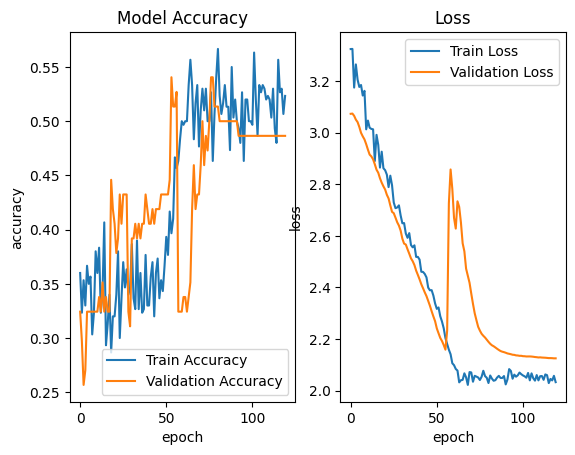

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(m6_hist.history['accuracy'], label='Train Accuracy')
ax1.plot(m6_hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend()
ax2.plot(m6_hist.history['loss'], label='Train Loss')
ax2.plot(m6_hist.history['val_loss'], label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.legend()
fig.show()

## Hyperparameter Tuning Conclusions

#### The most important hyperparameter was the dropout size. Increasing the dropout size did the most for preventing overfitting in my model. Other important hyperparameters were filter size, number of filters, and stride. Adding in stride also helped, as did increasing model depth and adjusting number of filters.

## Discussion and Conclusions

#### This model struggled a lot with overfitting. The small dataset made the model pretty unstable, and it struggled with accuracy and instability. To combat this, I could have tried using a pre-trained model with similar data and doing the final fit with this model. Further hyperparameter tuning also could have helped, along with loss function tuning. The final model ended up with an accuracy of around 50%. I think if I had reduced the starting learning rate and minimum learning rate and increased the number of epochs it's possible the model would have been more stable, but having only 100 images of each type just really reduced model efficacy.

#### The  most effective model improvements were with increasing the size of the dropout layers and adjusting the optimizer. The learning rate reducer really helped, and adjusting the loss function helped as well.

#### Another way I could have improved the model could have been by augmenting images and adding them to the dataset rather than just replacing images with augmentation.